In [1]:
import numpy as np
from scipy.optimize import nnls
import itertools as itt
import networkx as nx
import matplotlib.pyplot as plt
from mixsol import Powder, Solution, SolutionMaker, Mixer, calculate_molar_mass

In [2]:
powders = [
    Powder(
        formula='Cs_I',
    ),
    Powder(
        formula='Pb_I2',
    ),
    Powder(
        formula='Pb_Br2'
    ),
    Powder(
        formula='Pb_Cl2'
    ),
    Powder(
        'MA_I',
        molar_mass=calculate_molar_mass('C_H6_N_I'),
        alias='MAI',
    ),
    Powder(
        'FA_I',
        molar_mass = calculate_molar_mass('C_H5_N2_I'),
        alias='FAI',
        )
]

maker = SolutionMaker(
    powders=powders
)

In [3]:
maker.components

['MA', 'Pb', 'Cs', 'Cl', 'I', 'Br', 'FA']

In [10]:
target=Solution(
    solutes='Cs0.05_FA0.8_MA0.15_Pb_I2.4_Br0.45_Cl0.15',
    solvent='DMF9_DMS01',
    molarity=1
)

maker.get_weights(
    target,
    volume=1e-3, #in L
    tolerance=1e-5
)

7.453889935837843e-20


{'Cs_I': 0.012990496098000008,
 'Pb_I2': 0.3227062580000001,
 'Pb_Br2': 0.08257657499999997,
 'Pb_Cl2': 0.02085793499999998,
 'MAI': 0.023845433849999924,
 'FAI': 0.1375746568}

In [25]:
idx_to_use = list(range(maker.matrix.shape[0]))
for component_idx in np.where(tvec==0)[0]:
    present_in_powder = np.where(maker.matrix[:,component_idx] > 0)[0]
    for powder_idx in present_in_powder:
        idx_to_use.remove(powder_idx)

In [5]:
idx_to_use

NameError: name 'idx_to_use' is not defined

In [24]:
maker.matrix[:,1] > 0

array([ True,  True, False, False,  True,  True])

In [21]:
maker.matrix.shape

(6, 7)

In [ ]:
for component in 

In [18]:
maker.matrix[:,1] > 0

array([ True,  True, False, False,  True,  True])

In [16]:
np.logical_and(tvec>0 , maker.matrix[0]>0)

array([False,  True, False, False, False, False,  True])

In [14]:
tvec>0

array([False,  True,  True, False, False, False,  True])

In [15]:
maker.matrix>0

array([[False,  True, False, False, False, False,  True],
       [False,  True,  True, False, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False,  True, False,  True, False, False],
       [ True,  True, False, False, False, False, False],
       [False,  True, False, False, False,  True, False]])

In [10]:
maker.matrix

array([[0.        , 0.00384897, 0.        , 0.        , 0.        ,
        0.        , 0.00384897],
       [0.        , 0.00433831, 0.00216916, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.00272474, 0.00544949, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.00359575, 0.        , 0.00719151,
        0.        , 0.        ],
       [0.00629051, 0.00629051, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.00581502, 0.        , 0.        , 0.        ,
        0.00581502, 0.        ]])

Solutions

In [4]:
stock_solutions = [
    Solution(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1,
        alias='FAPI'
    ),
    Solution(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1,
        alias='MAPI'
    ),
    
]

# densetargets = []
# for a in np.logspace(0, -3, 10):
#     densetargets.append(Solution(
#         solutes=f"FA{a:0.3f}_MA{1-a:.3f}_Pb_I3",
#         solvent="DMF9_DMSO1",
#         molarity=1,
#         alias=f'FA_{a:.3f}'
#     ))


densetargets = []
for a in np.linspace(0, 0.8, 10):
    densetargets.append(Solution(
        solutes=f"FA{a:0.3f}_MA{1-a:.3f}_Pb_I3",
        solvent="DMF9_DMSO1",
        molarity=1,
        alias=f'FA_{a:.3f}'
    ))

In [5]:
sm = Mixer(stock_solutions, {t:60 for t in densetargets})

In [6]:
sm.solve(min_volume=20, max_inputs = 3)

In [7]:
sm.print()

===== Stock Prep =====
240.00 of FAPI
360.00 of MAPI
====== Mixing =====
Distribute FAPI:
	72.30 to FA_0.356
	63.26 to FA_0.444
	76.19 to FA_0.711
	28.25 to FA_0.800
Distribute MAPI:
	130.79 to FA_0.356
	79.21 to FA_0.444
	60.00 to FA_0.178
	30.00 to FA_0.089
Distribute FA_0.356:
	60.00 to FA_0.178
	30.00 to FA_0.267
	53.09 to FA_0.533
Distribute FA_0.444:
	82.47 to FA_0.711
Distribute FA_0.178:
	30.00 to FA_0.089
	30.00 to FA_0.267
Distribute FA_0.711:
	52.79 to FA_0.533
	45.87 to FA_0.622
Distribute FA_0.533:
	45.87 to FA_0.622
Distribute FA_0.622:
	31.75 to FA_0.800


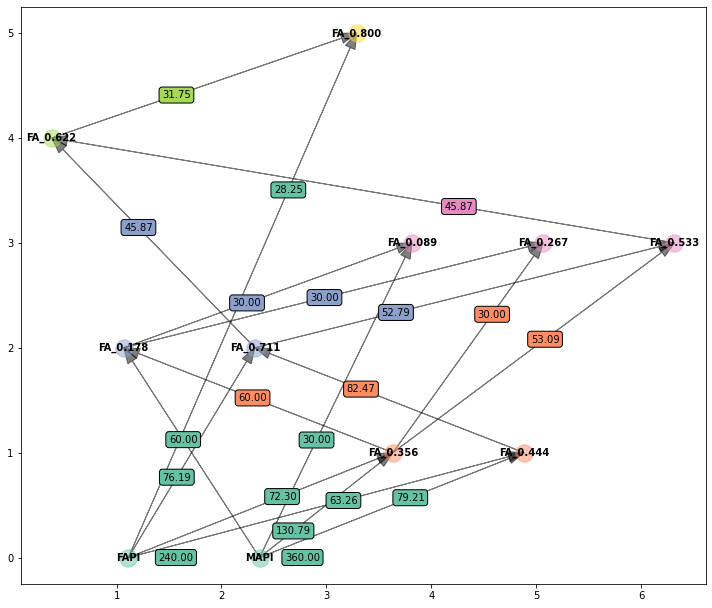

In [8]:
sm.plot()